### Twitter Web-Scraping + Sentiment Analysis + Visualizations ETL Pipeline

#### Necessary Imports

In [100]:
import pandas as pd # DataFrames
import numpy # Numerical Calculations
import os # operating system

# Data Visualizations
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

# Smart Progress Meter
from tqdm.notebook import tqdm

# NLP
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Twitter WebScraper
import snscrape.modules.twitter as sntwitter

# Import this and insert this to center jupyter notebook visualizations output
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

#### Function to Scrape Tweets into DataFrame + Vaders Sentiment Scores + Display and Save Visualizations

In [107]:
# Note: no @ before username - only required parameter, rest you can alter but will run as defualt
# Default to True to display and save visualizations
#            True to include Vaders Score in output df and csv
# Note: You will need to set display_visualiztions=True if you want to save visualizations 

def scrape_and_sentiment_tweets(username,
                                vaders=True,
                                save_to_csv=True,
                                display_visualizations=True,
                                save_visualizations=True):
    
    # Define twitter webscrpaer to scrape tweets from defined username
    scraper = sntwitter.TwitterSearchScraper(f'from:{username}')
    
    # Create list from iterated data with desired twitter data
    tweets = []
    print('\033[1m' + 'Scraping Tweets:' + '\033[0m')
    for i, tweet in tqdm(enumerate(scraper.get_items())):
        data = [
            tweet.date,
            tweet.user.username,
            tweet.content,
            tweet.likeCount,
            tweet.retweetCount
            ]
        tweets.append(data)
    
    # Create pandas data frame from tweets list
    df = pd.DataFrame(tweets, columns=['date',
                                       'username',
                                       'content',
                                       'like_count',
                                       'retweet_count'])
    
    # Insert column with index values (used for later dataframe merging)
    df.insert(loc=0, column='index', value=[i for i in range(len(df))])
    
    # Vaders NLTK Sentiment Analysis
    if (vaders==True):
        # Define Vaders sentiment intensity analzer
        sia = SentimentIntensityAnalyzer()

        # Iterate through rows content, determining vaders sentiment analysis for each tweet
        res = {}
        print('\033[1m' + 'NLTK Vaders Analysis on Tweets:' + '\033[0m')
        for i, row in tqdm(df.iterrows(), total=len(df)):
            content = row['content']
            index = row['index']
            res[index] = sia.polarity_scores(content)
        vaders_df = pd.DataFrame(res).T
        vaders_df.insert(loc=0, column='index', value=[i for i in range(len(vaders_df))])

        # Merge vaders sentiment analysis scores onto tweets data frame
        df = df.merge(vaders_df, how="left")
        
    
    if (save_to_csv==True):
        # Save pandas dataframe to csv
        data_dir = f'tweet_sentiment_data_{username}'
        if not os.path.exists(data_dir):
            os.makedirs(data_dir)
        df.to_csv(data_dir+"//data.csv")
    
    
    ## Data Visualizations
    
    if (display_visualizations == True):
        
        print('\033[1m' + 'Data Visualizations:' + '\033[0m')
        
        # Create Data Dir in case user doesnt want to save to csv
        if (save_to_csv==False):
            data_dir = f'tweet_sentiment_data_{username}'
            if not os.path.exists(data_dir):
                os.makedirs(data_dir)
        
        if (save_visualizations==True):
            # Define Data Visualizations Directory to save visualizations 
            visualizations_dir = data_dir+'//visualizations//'
            if not os.path.exists(visualizations_dir):
                os.makedirs(visualizations_dir)

        # Pie Chart for Sentiment Score Distribution
        plt.figure(figsize=(8,5), dpi=100)
        data = [df['pos'].mean(),
                df['neu'].mean(),
                df['neg'].mean()]
        labels = ['Positive', 'Neutral', 'Negative']
        colors = ["Green", "Orange", "Red"]
        explode = (.03, .03, .03)
        plt.title(f"Vaders Sentiment Score Distribution \nfor all {username} tweets")
        plt.pie(data,
                labels = labels,
                colors = colors,
                explode = explode,
                pctdistance=0.7,
                autopct='%.1f%%')
        if (save_visualizations==True):
            plt.savefig(visualizations_dir+"Sentiment_Pie.png")
        plt.show()

        # Pie Chart for Sentiment Score Distribution
        fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
        sns.barplot(data=df,  y="pos", ax=axs[0], color="green")
        sns.barplot(data=df,  y="neu", ax=axs[1], color="orange")
        sns.barplot(data=df,  y="neg", ax=axs[2], color = "red")
        axs[0].set_title('Positive')
        axs[1].set_title('Neutral')
        axs[2].set_title('Negative')
        fig.suptitle(f"Vaders Sentiment Score Distribution for all {username} Tweets", fontsize=20)
        plt.tight_layout()
        if (save_visualizations==True):
            plt.savefig(visualizations_dir+"Sentiment_Bar.png")
        plt.show()

        # Scatter Plot over time
        plt.figure(figsize=(10,5), dpi=100)
        score_polarity=df.sort_values(by=['compound'], ascending=True)['compound']
        ax = sns.scatterplot(data=df,
                             x="date",
                             y="compound",
                             hue=score_polarity,
                             palette=sns.color_palette("coolwarm", as_cmap=True),
                             legend=False)\
                            .set(title=f"Vaders Compound Scores over Time for {username}")
        plt.xticks(rotation=50)
        if (save_visualizations==True):
            plt.savefig(visualizations_dir+"Sentiment_Scatter_OverTime.png")
        plt.show()
    
    
    # Return DataFrame 
    return df

Scraping Tweets:


0it [00:00, ?it/s]

NLTK Vaders Analysis on Tweets:


  0%|          | 0/2090 [00:00<?, ?it/s]

Data Visualizations:


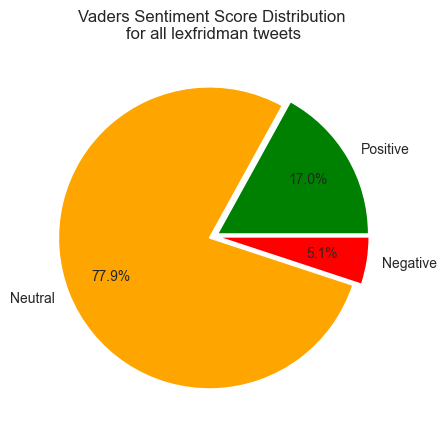

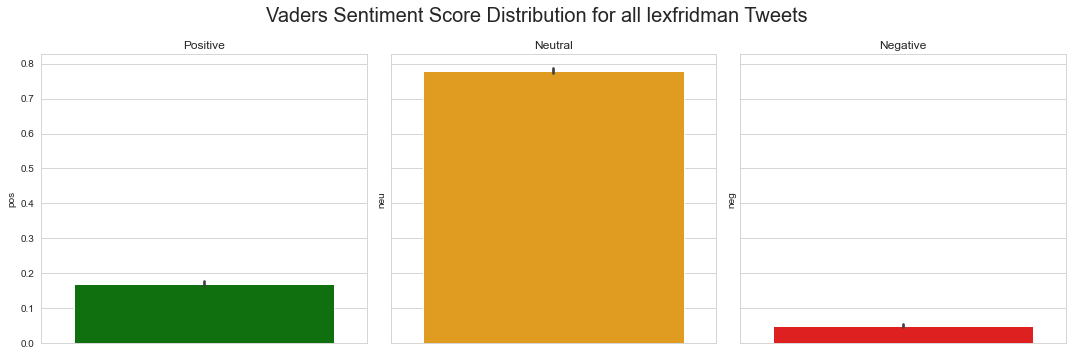

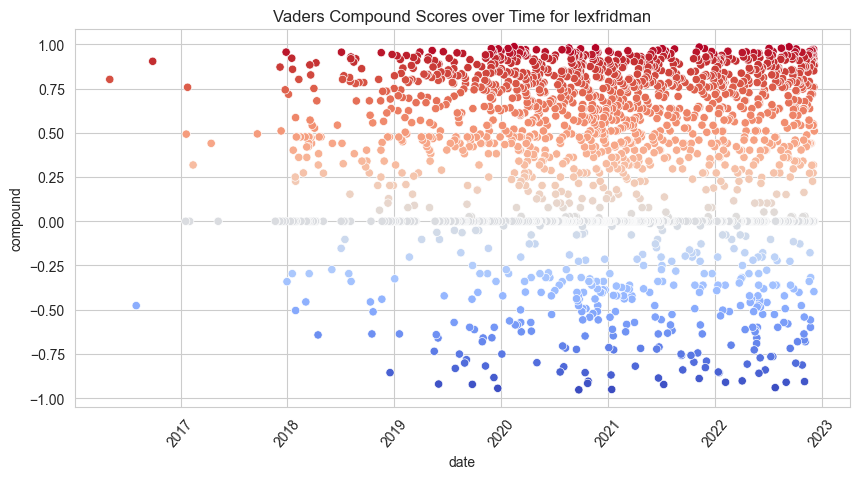

In [112]:
df = scrape_and_sentiment_tweets('lexfridman')

#### Print dataframe shape

In [113]:
df.shape

(2090, 10)

#### Display DataFrame Head

In [114]:
df.head()

,index,date,username,content,like_count,retweet_count,neg,neu,pos,compound
0,0,2022-12-06 01:02:43+00:00,lexfridman,@MrBeast On my way 🤣,1028,15,0.000,1.000,0.000,0.0000
1,1,2022-12-05 22:32:11+00:00,lexfridman,@MrBeast Impressive resume @MrBeast,3297,24,0.000,0.476,0.524,0.5106
2,2,2022-12-05 18:43:22+00:00,lexfridman,I'm hiring to help with podcast. We have a sma...,13450,707,0.000,0.769,0.231,0.8860
3,3,2022-12-05 01:14:14+00:00,lexfridman,Don't live in an idea bubble. Surround yoursel...,46120,6237,0.063,0.591,0.346,0.8793
4,4,2022-12-04 19:18:01+00:00,lexfridman,I appreciate the emotional honesty of this pie...,18966,1236,0.000,0.483,0.517,0.7579


#### Display Dataframe Tail

In [115]:
df.tail()

,index,date,username,content,like_count,retweet_count,neg,neu,pos,compound
2085,2085,2017-01-20 11:37:47+00:00,lexfridman,@Mimi_Auner Thanks! Next one up this weekend a...,2,0,0.000,0.842,0.158,0.4926
2086,2086,2017-01-18 14:26:18+00:00,lexfridman,@acrosson Working on it!,1,0,0.000,1.000,0.000,0.0000
2087,2087,2016-09-27 21:25:20+00:00,lexfridman,"@snagglechud yep, I did it originally for my o...",1,0,0.000,0.621,0.379,0.9042
2088,2088,2016-08-02 12:58:37+00:00,lexfridman,@Forbes exactly and we at MIT have developed a...,2,0,0.154,0.846,0.000,-0.4767
2089,2089,2016-05-04 04:12:26+00:00,lexfridman,@nudehaberdasher @dotMudge @0xcharlie I've nev...,3,0,0.000,0.675,0.325,0.8020
